need to use colab for gpus

1. Setup and Load Data

1.1 Install Dependencies and Setup

In [312]:
import os
import cv2
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import torchvision.models.segmentation
import torch
import torchvision.transforms as T
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import scipy.io
from sklearn.model_selection import train_test_split
import random
from torchviz import make_dot
import torch.optim as optim
from torchsummary import summary

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 200
batch_size = 256

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# If you are on CoLab and successfully using the GPU, this print should
#   contain "cuda" in it
print(str(device))
assert('cuda' in str(device))  # comment out this assert if you are not using a GPU

torch.cuda.empty_cache()

cuda:0


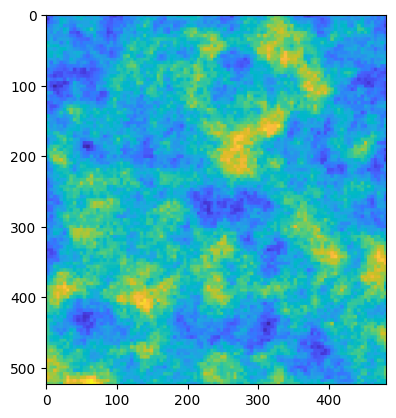

In [313]:
x = cv2.cvtColor(cv2.imread('trainingdataimages/gentrain_001.png'), cv2.COLOR_BGR2RGB)
x
plt.imshow(x)

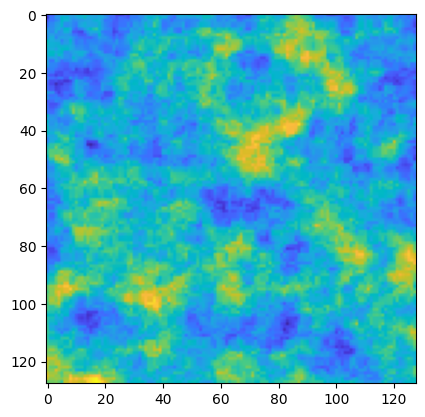

In [314]:
x = cv2.resize(x, (128,128), interpolation=cv2.INTER_LINEAR)
plt.imshow(x)

In [315]:
image = Image.open('trainingdataimages/gentrain_001.png')
data = np.asarray(image)
data

array([[[139, 154, 252],
        [ 70,  93, 250],
        [ 70,  93, 250],
        ...,
        [ 62, 111, 254],
        [ 62, 111, 254],
        [ 62, 111, 254]],

       [[139, 154, 252],
        [ 70,  93, 250],
        [ 70,  93, 250],
        ...,
        [ 62, 111, 254],
        [ 62, 111, 254],
        [ 62, 111, 254]],

       [[139, 154, 252],
        [ 70,  93, 250],
        [ 70,  93, 250],
        ...,
        [ 62, 111, 254],
        [ 62, 111, 254],
        [ 62, 111, 254]],

       ...,

       [[157, 223, 165],
        [ 99, 204, 111],
        [ 99, 204, 111],
        ...,
        [  1, 186, 195],
        [  1, 186, 195],
        [  1, 186, 195]],

       [[157, 223, 165],
        [ 99, 204, 111],
        [ 99, 204, 111],
        ...,
        [  1, 186, 195],
        [  1, 186, 195],
        [  1, 186, 195]],

       [[157, 223, 165],
        [ 99, 204, 111],
        [ 99, 204, 111],
        ...,
        [  1, 186, 195],
        [  1, 186, 195],
        [  1, 186, 195]]

theta: ([,], [0,3], [0, 1])

In [316]:
import tqdm

image_list = []
theta_list = []

directory = 'trainingdataimages'

i = 0

# iterate over files in
# that directory
for filename in tqdm.tqdm(os.listdir(directory)):
    # print(filename)
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        # Opens a image in RGB mode
        image = Image.open(f)
        data = np.asarray(image)
        data = cv2.resize(data, (128,128), interpolation=cv2.INTER_LINEAR)
        matfile = 'trainingdatavalues/' + filename[:len(filename) - 4] + '.mat'
        mat = scipy.io.loadmat(matfile)
        image_list.append(data)
        theta_list.append(mat['th0'][0])
        i += 1
        if i > 100:
            break

print(image_list[0].shape)
print(theta_list[0])

theta_list = np.asarray(theta_list)
image_list = np.asarray(image_list)

image_list = np.moveaxis(image_list, -1, 1)
theta_list = np.moveaxis(theta_list, -1, 1)

# print(theta_list)

print(image_list.shape)

# image_train, image_test, theta_train, theta_test = train_test_split(image_list, theta_list)

# print(image_train.shape)

image_list = torch.tensor(image_list).float()
# print(image_list)
theta_list = torch.tensor(theta_list)
print(theta_list)

# image_list.shape

 11%|█         | 100/934 [00:00<00:04, 166.90it/s]

(128, 128, 3)
[1.48230471e+06 5.61676640e-01 3.45080000e+04]
(101, 3, 128, 128)
tensor([[1.4823e+06, 5.6168e-01, 3.4508e+04],
        [2.0300e+06, 1.9399e+00, 3.0180e+03],
        [2.3829e+06, 6.5020e-01, 1.9936e+04],
        [2.1118e+06, 8.3978e-01, 3.4907e+04],
        [2.9032e+06, 4.8436e-01, 4.8810e+03],
        [2.7434e+06, 2.2697e+00, 4.0014e+04],
        [1.0015e+06, 1.7722e+00, 1.1414e+04],
        [1.1152e+06, 2.0973e+00, 4.0583e+04],
        [3.0909e+06, 2.2756e+00, 2.8377e+04],
        [2.7525e+06, 1.7599e+00, 4.7650e+03],
        [1.2645e+06, 5.8828e-01, 3.7905e+04],
        [2.9637e+06, 2.2607e+00, 2.9890e+04],
        [3.9898e+06, 2.5857e+00, 7.3350e+03],
        [2.4869e+06, 2.9705e+00, 6.2110e+03],
        [1.2109e+06, 2.1452e-01, 3.2620e+03],
        [2.9395e+06, 1.7421e+00, 4.1490e+03],
        [2.1004e+06, 2.8444e+00, 2.3286e+04],
        [2.0169e+06, 1.4488e-01, 2.2549e+04],
        [3.5644e+06, 7.5328e-01, 1.1834e+04],
        [2.8893e+06, 1.3272e+00, 9.3650e+03],


In [317]:
# normalize data:

# images
imean = torch.std(image_list, dim=0)
istd = torch.mean(image_list, dim=0)
# image_tensor = torch.div(torch.sub(image_list, imean), istd)
image_tensor = torch.div(image_list, 255).float()
print(image_tensor)

# theta
tmean = torch.std(theta_list, dim=0)
tstd = torch.mean(theta_list, dim=0)
theta_tensor = torch.div(torch.sub(theta_list, tmean), tstd).float()
print(theta_tensor)

tensor([[[[0.2745, 0.2745, 0.2745,  ..., 0.2431, 0.1686, 0.2431],
          [0.2706, 0.2196, 0.2196,  ..., 0.2431, 0.1725, 0.2588],
          [0.2784, 0.2196, 0.2196,  ..., 0.1765, 0.2431, 0.2784],
          ...,
          [0.8627, 0.6706, 0.6706,  ..., 0.0000, 0.0941, 0.2431],
          [0.7725, 0.5608, 0.5608,  ..., 0.0941, 0.0039, 0.0431],
          [0.3882, 0.4431, 0.4431,  ..., 0.0000, 0.0039, 0.0039]],

         [[0.3647, 0.3647, 0.3647,  ..., 0.4353, 0.5686, 0.4353],
          [0.2118, 0.4588, 0.4588,  ..., 0.4353, 0.5490, 0.4118],
          [0.3412, 0.4588, 0.4588,  ..., 0.5255, 0.4353, 0.3412],
          ...,
          [0.7373, 0.7765, 0.7765,  ..., 0.7176, 0.7490, 0.7882],
          [0.7569, 0.7922, 0.7922,  ..., 0.7490, 0.7294, 0.7373],
          [0.8000, 0.8000, 0.8000,  ..., 0.7176, 0.7294, 0.7294]],

         [[0.9804, 0.9804, 0.9804,  ..., 0.9961, 0.9333, 0.9961],
          [0.8353, 0.9961, 0.9961,  ..., 0.9961, 0.9490, 0.9922],
          [0.9686, 0.9961, 0.9961,  ..., 0

In [318]:
image_train, image_test, theta_train, theta_test = train_test_split(image_tensor, theta_tensor)

In [319]:
train_dataset = TensorDataset(image_train, theta_train)
print(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
print(train_loader)

test_dataset = TensorDataset(image_test, theta_test)
print(test_dataset)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
print(test_loader)

In [320]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2) 
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2) 
        self.pool3 = nn.MaxPool2d(2, 2)

        self.size_linear = 128*16*16
        self.fc1 = nn.Linear(self.size_linear, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 3)


    def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x))) 
            x = self.pool2(F.relu(self.conv2(x))) 
            x = self.pool3(F.relu(self.conv3(x)))
            x = x.view(-1, self.size_linear) # this flattens x into a 1D vector
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x)) 
            x = self.fc3(x)
            return x

In [321]:
##ASSERT: checks if CNN has the correct output shape
with torch.no_grad():  # tells PyTorch not to track gradients here
    # test_data is 100 random images, 3 channel2, 128-by-128
    test_data = torch.rand(100,3,128,128)
    test_net = ConvNet()
    out = test_net.forward(test_data)
    # the output should have size (100,3)
    print(out)
    print(out.size())
    assert(out.size()==(100,3))

    print(out[0][0])

tensor([[ 0.0558,  0.0280, -0.0128],
        [ 0.0583,  0.0285, -0.0110],
        [ 0.0565,  0.0299, -0.0122],
        [ 0.0578,  0.0293, -0.0110],
        [ 0.0577,  0.0286, -0.0142],
        [ 0.0575,  0.0291, -0.0115],
        [ 0.0565,  0.0282, -0.0121],
        [ 0.0572,  0.0289, -0.0116],
        [ 0.0551,  0.0295, -0.0128],
        [ 0.0577,  0.0281, -0.0110],
        [ 0.0561,  0.0293, -0.0126],
        [ 0.0570,  0.0277, -0.0123],
        [ 0.0566,  0.0273, -0.0124],
        [ 0.0554,  0.0275, -0.0109],
        [ 0.0545,  0.0289, -0.0115],
        [ 0.0563,  0.0282, -0.0105],
        [ 0.0565,  0.0298, -0.0116],
        [ 0.0569,  0.0281, -0.0127],
        [ 0.0585,  0.0284, -0.0111],
        [ 0.0570,  0.0286, -0.0125],
        [ 0.0568,  0.0285, -0.0117],
        [ 0.0568,  0.0289, -0.0123],
        [ 0.0560,  0.0284, -0.0100],
        [ 0.0578,  0.0291, -0.0116],
        [ 0.0566,  0.0280, -0.0110],
        [ 0.0570,  0.0290, -0.0124],
        [ 0.0565,  0.0293, -0.0128],
 

In [322]:
class Trainer():
    def __init__(self,net=None,optim=None,loss_function=None, train_loader=None):
        self.net = net
        self.optim = optim
        self.loss_function = loss_function
        self.train_loader = train_loader

    def train(self,epochs):
        losses = []
        for epoch in range(epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            for data in self.train_loader:
                
                # Moving this batch to GPU
                # Note that X has shape (batch_size, number of channels, height, width)
                # which is equal to (256,3,128,128) since our default batch_size = 256 and 
                # the image has only 1 channel
                X = data[0].to(device)
                y = data[1].to(device)
                
                # print(X[0])
                # plt.imshow(np.moveaxis(X[0].cpu().numpy(), 0, -1))

                
                # Zero the gradient in the optimizer i.e. self.optim
                self.optim.zero_grad()

                # Getting the output of the Network
                out = self.net(X)

                # Computing loss using loss function i.e. self.loss_function
                loss = self.loss_function(out, y)

                # Backpropagate to compute gradients of parameteres
                loss.backward()

                # Call the optimizer i.e. self.optim
                self.optim.step()

                epoch_loss += loss.item()
                epoch_steps += 1
            # average loss of epoch
            losses.append(epoch_loss / epoch_steps)
            print("epoch [%d]: loss %.3f" % (epoch+1, losses[-1]))
        return losses

In [323]:
### try different learning rates for SGD to see which one works (do not try learning rates greater than 1)
### we want the last epoch loss to be less than 0.03
learning_rate = 0.001 #ACT16

net = ConvNet()
net = net.to(device)
# opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
opt = optim.Adam(net.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

trainer = Trainer(net=net, optim=opt, loss_function=loss_function, train_loader=train_loader)

losses = trainer.train(num_epochs)


epoch [1]: loss 0.382
epoch [2]: loss 0.340
epoch [3]: loss 0.335
epoch [4]: loss 0.306
epoch [5]: loss 0.256
epoch [6]: loss 0.235
epoch [7]: loss 0.201
epoch [8]: loss 0.170
epoch [9]: loss 0.131
epoch [10]: loss 0.116
epoch [11]: loss 0.105
epoch [12]: loss 0.121
epoch [13]: loss 0.194
epoch [14]: loss 0.124
epoch [15]: loss 0.085
epoch [16]: loss 0.086
epoch [17]: loss 0.104
epoch [18]: loss 0.074
epoch [19]: loss 0.075
epoch [20]: loss 0.087
epoch [21]: loss 0.093
epoch [22]: loss 0.098
epoch [23]: loss 0.143
epoch [24]: loss 0.078
epoch [25]: loss 0.071
epoch [26]: loss 0.083
epoch [27]: loss 0.107
epoch [28]: loss 0.131
epoch [29]: loss 0.092
epoch [30]: loss 0.077
epoch [31]: loss 0.089
epoch [32]: loss 0.058
epoch [33]: loss 0.042
epoch [34]: loss 0.025
epoch [35]: loss 0.021
epoch [36]: loss 0.025
epoch [37]: loss 0.027
epoch [38]: loss 0.042
epoch [39]: loss 0.082
epoch [40]: loss 0.052
epoch [41]: loss 0.071
epoch [42]: loss 0.040
epoch [43]: loss 0.040
epoch [44]: loss 0.0

Text(0, 0.5, 'training loss')

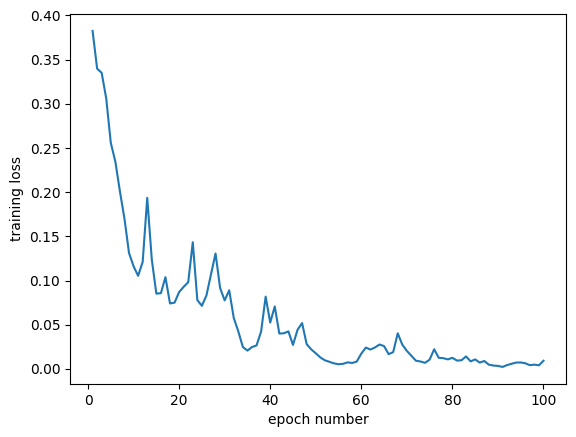

In [324]:
import matplotlib.pyplot as plt
### plot the training loss (y-axis) vs epoch number (x-axis)
### using the losses computed
plt.plot(range(1,num_epochs+1), losses)
plt.xlabel("epoch number")
plt.ylabel("training loss")

In [325]:
err1 = 0
err2 = 0
err3 = 0
tot = 0
with torch.no_grad():
    for data in test_loader:
        # retrieve X and y for this batch, from data, and 
        # move it to the device you are using (probably the GPU)
        X = data[0].to(device)
        y = data[1].to(device)

        # raw output of network for X
        output = net(X)
        
        # let the maximum index be our predicted class
        # _, yh = torch.max(output, 1) 

        # tot will 10,000 at the end, total number of test data
        tot += y.size(0)

        ## add to err number of missclassification, i.e. number of indices that 
        ## yh and y are not equal
        ## note that y and yh are vectors of size = batch_size = (256 in our case)
        # err += (y != yh).sum()

        errors = output.sub(y).multiply(output.sub(y)).div(batch_size).sum(axis=0)
        err1 += errors[0]
        err2 += errors[1]
        err3 += errors[2]

print(tot)
print(err1)
print(err2)
print(err3)

print('Accuracy of prediction on test (1): %5.2f%%' % (100-100 * err1 / tot))

print('Accuracy of prediction on test (2): %5.2f%%' % (100-100 * err2 / tot))

print('Accuracy of prediction on test (3): %5.2f%%' % (100-100 * err3 / tot))

###ASSERTS
# assert((100-100 * err / tot)>=98)
# assert(tot==10*1000)

26
tensor(0.0141, device='cuda:0')
tensor(0.0459, device='cuda:0')
tensor(0.0417, device='cuda:0')
Accuracy of prediction on test (1): 99.95%
Accuracy of prediction on test (2): 99.82%
Accuracy of prediction on test (3): 99.84%
